## Amazon Product Recommendation with Sentimental Analysis

In [558]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import gzip
import json
import spacy
import re
import random

from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
from textblob import TextBlob


from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, RobustScaler
from itertools import cycle


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import lightgbm
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

pd.options.mode.chained_assignment = None

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chaer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\chaer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chaer\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


##### Import Json file (Amazon Home and Kitchen Data)

In [2]:
# reading in the data (sample code was given by creators)
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

home_and_kitchen = getDF('Home_and_Kitchen_5.json.gz')

In [3]:
# slice original dataset 
df = home_and_kitchen.copy(deep = True)

In [4]:
# first look into data
df.head(5)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"11 5, 2015",A8LUWTIPU9CZB,0560467893,Linda Fahner,"Great product, love it!!",Five Stars,1446681600,NaN,NaN,NaN
1,3.0,True,"05 7, 2015",A3B6GKQQ1JJ167,0560467893,Harry Slaughter,"Pretty flimsy, but does the job. If your corne...",Meh,1430956800,2,NaN,NaN
2,5.0,True,"01 22, 2014",A3MCTN65BU7XRA,0681795107,luckyg,So much better than plastic mug types--keeps c...,Recommend,1390348800,NaN,{'Color:': ' Brushed Stainless'},NaN
3,1.0,True,"10 30, 2013",A7JVZFSXVY9RL,0681795107,Nickleen,I like my coffee hot; borderline scorching but...,Not keeping coffee hot for long enough,1383091200,NaN,{'Color:': ' Brushed Stainless'},NaN
4,1.0,True,"09 20, 2013",A2RQ7VLAK1SHPU,0681795107,Lacemaker427,This mug does only a fair job of keeping coffe...,Leaks like a waterfall when at an angle!,1379635200,NaN,{'Color:': ' Red'},NaN


##### Initial Data Cleaning (Missing Values)

In [5]:
# see the missing values
df.isnull().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName          519
reviewText           2581
summary              1301
unixReviewTime          0
vote              5945961
style             2638003
image             6707517
dtype: int64

Only focused on reviewText and overall for model building. <br>
Drop missing values only from these columns

In [6]:
# drop missing values in the column reviewText
df = df.dropna(subset = ['reviewText'])

### Exploratory Data Analysis

In [7]:
# dimensions of dataframe
df.shape

(6896374, 12)

In [8]:
# missing values are removed from the column reviewText
df.isnull().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName          515
reviewText              0
summary              1211
unixReviewTime          0
vote              5943865
style             2637054
image             6706253
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6896374 entries, 0 to 6898954
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   verified        bool   
 2   reviewTime      object 
 3   reviewerID      object 
 4   asin            object 
 5   reviewerName    object 
 6   reviewText      object 
 7   summary         object 
 8   unixReviewTime  int64  
 9   vote            object 
 10  style           object 
 11  image           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 638.0+ MB


In [13]:
# checking the type of object in the series
print(type(df.overall[0]))

<class 'numpy.int32'>


In [16]:
# convert the ratings to type integer
df['overall'] = df['overall'].astype('int')

In [17]:
# statistics on overall column
df.overall.describe()

count    6.896374e+06
mean     4.358340e+00
std      1.132023e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: overall, dtype: float64

Average rating of reviews: 4.35 (very high) <br>
Standard deviation: 1.13 <br>
Most of reviews are positive (3 stars and up)

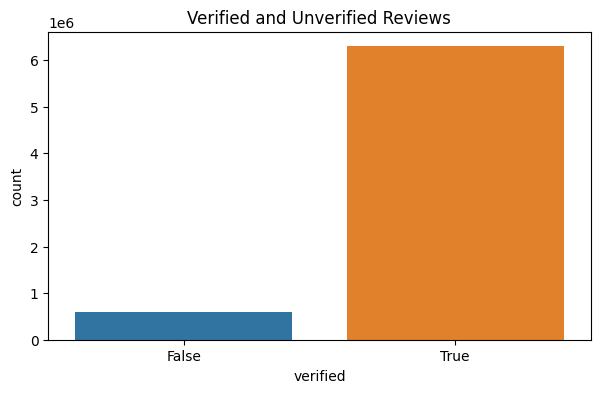

In [19]:
# plot of verified and unverified reviews
plt.figure(figsize=(7,4))
sns.countplot(x = 'verified', data = df)
plt.title('Verified and Unverified Reviews')
plt.show()

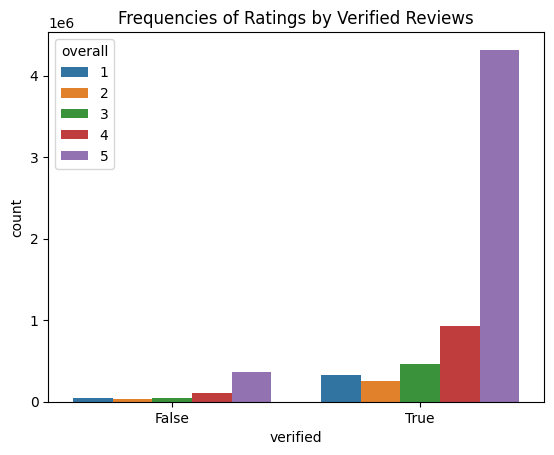

In [20]:
sns.countplot(x = 'verified', hue = 'overall', data = df)
plt.title('Frequencies of Ratings by Verified Reviews')
plt.show()

Unverified reviews might have not been checked yet. <br>
Distribution of false and true reviews are similar.<br>
We will keep all reviews whether or not verified

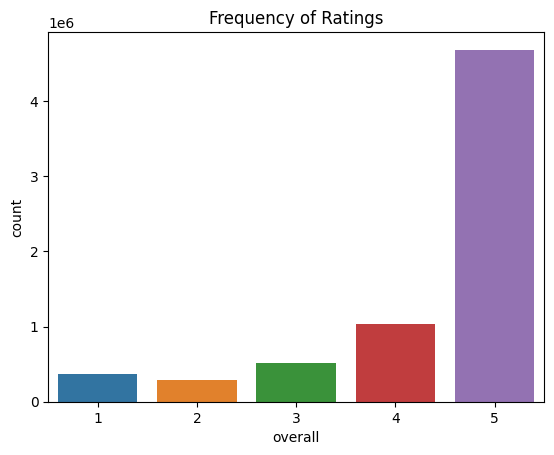

In [21]:
# frequency of each rating
sns.countplot(x = 'overall', data = df)
plt.title('Frequency of Ratings')
plt.show()

Most of the reviews were given 5 star ratings <br>
Highly imbalanced dataset

c:\Users\chaer\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


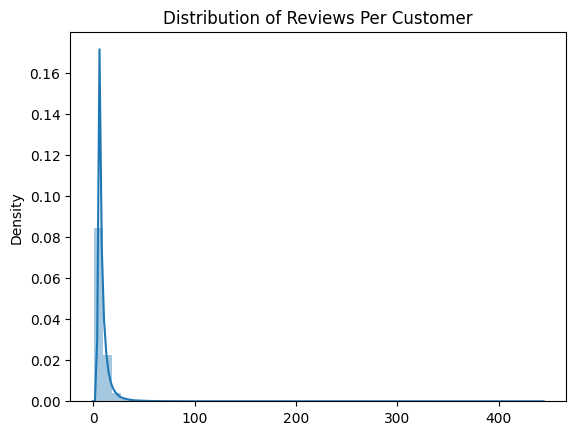

The median number of reviews per customer is 7.0


In [31]:
# distribution of reviews per customer
sns.distplot(df.groupby('reviewerID')['overall'].count().values)
plt.title('Distribution of Reviews Per Customer')
plt.show()

# use median due to the heavy skewed distribution of reviews
print('The median number of reviews per customer is', round(np.median(np.array([df.groupby('reviewerID')['overall'].count().values])), 2))

##### Word Clouds

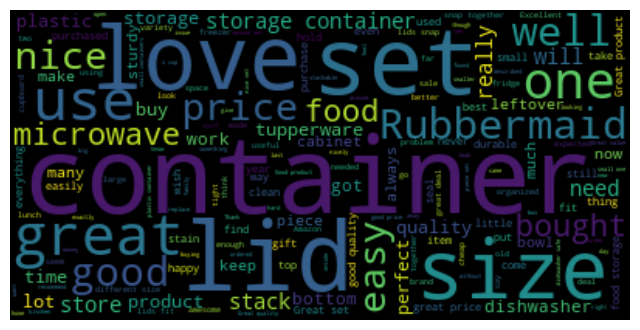

In [32]:
# creating word cloud for a product ID (Rubbermaid Easy Find Lids Food Storage Containers, Racer Red, 42 Piece Set)
text = ''
product_id = 'B00COK3FD8'
samp = df[df['asin'] == product_id]['reviewText'].reset_index(drop = True)

for i in range(len(samp)):
    text += ' ' + samp[i]

word_cloud = WordCloud().generate(text)
plt.figure(figsize = (8,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Overall positive: <br>
love <br>
great <br>
good <br>
perfect

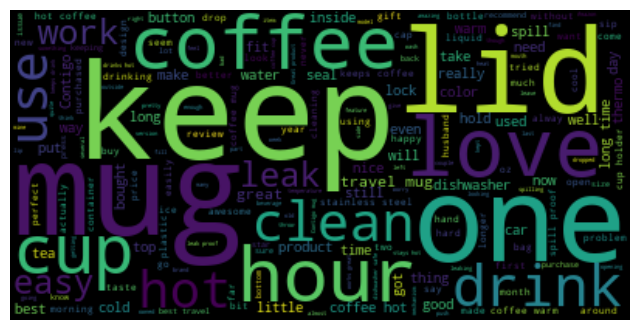

In [33]:
# creating word cloud for a product ID (Contigo Autoseal West Loop - Vacuum Insulated Stainless Steel Thermal Coffee Travel Mug)
text = ''
product_id = 'B009HVH4XO'
samp = df[df['asin'] == product_id]['reviewText'].reset_index(drop = True)

for i in range(len(samp)):
    text += ' ' + samp[i]

word_cloud = WordCloud().generate(text)
plt.figure(figsize = (8,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Overall Positive: <br>
love <br>
best <br>

##### Looking at Reviews Over Time

In [34]:
# splitting reviewTime into days, months, and years
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df['day'] = df['reviewTime'].dt.day
df['month'] = df['reviewTime'].dt.month 
df['year'] = df['reviewTime'].dt.year

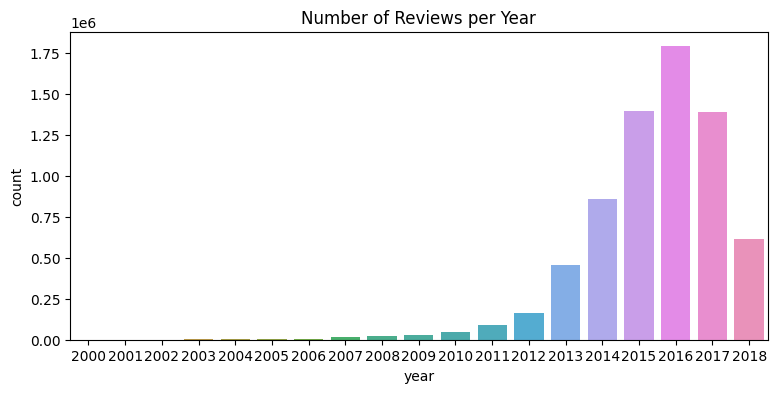

In [35]:
# plotting number of orders per year
plt.figure(figsize = (9, 4))
sns.countplot(x = 'year', data = df)
plt.title('Number of Reviews per Year')
plt.show()

The majority of reviews come from after 2014 <br>
The popularity of home and kitchen goods seems to increase dramatically after 2013 <br>
Most reviews comes from 2016 <br>
Only part of the reviews were collected in 2018

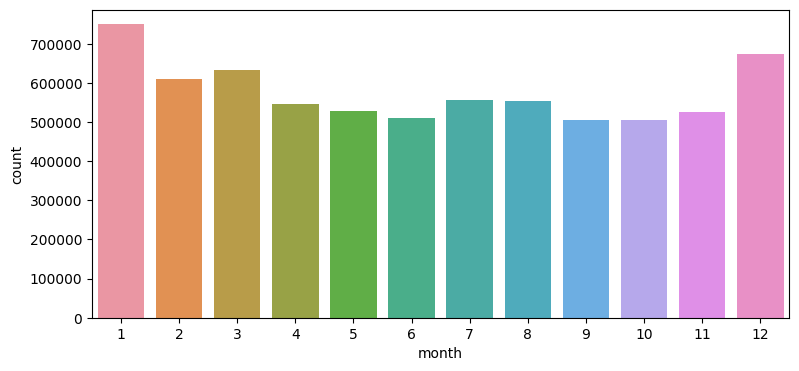

In [39]:
# plotting number of orders per month
plt.figure(figsize = (9, 4))
sns.countplot(x = 'month', data = df)
plt.show()

Distribution of reviews among the months are similar with the exception of January and December. <br>
Increased customer traffic for the holidays <br>
Most reviews posted in the first month of the year

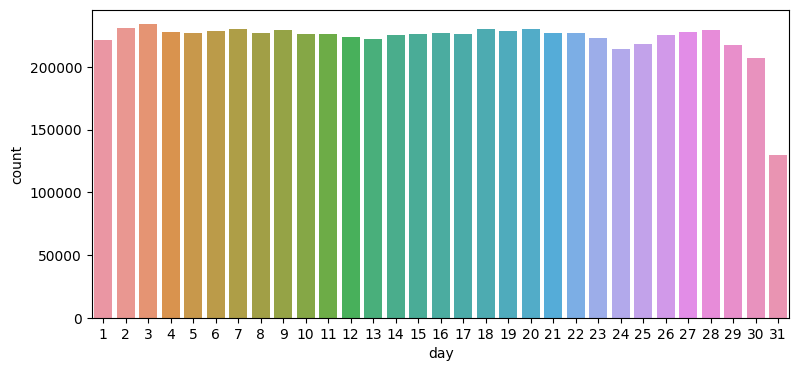

In [40]:
# plotting number of orders per day
plt.figure(figsize = (9, 4))
sns.countplot(x = 'day', data = df)
plt.show()

Distribution of reviews among the days are similar <br>
No explanation for decrease in reviews in the end of the month

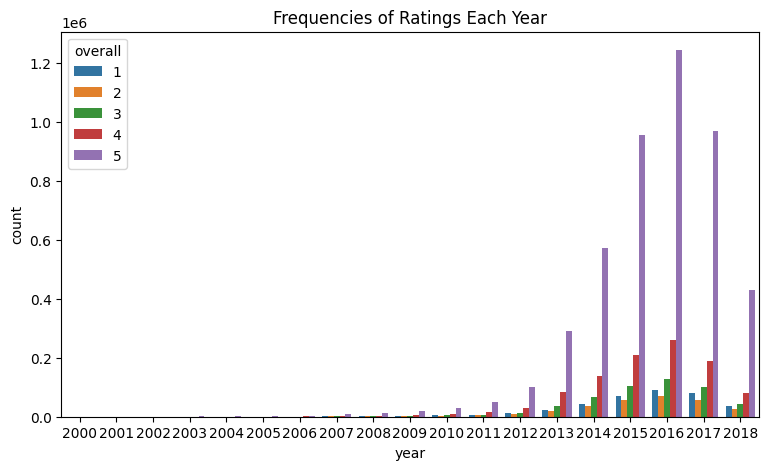

In [41]:
plt.figure(figsize = (9,5))
sns.countplot(x = 'year', hue = 'overall', data = df)
plt.title('Frequencies of Ratings Each Year')
plt.show()

Distribution of review ratings is similar with the distribution of reviews over the years <br>
Increases until 2016 and drops afterwards <br>
2 star ratings are consistently lower than other ratings <br>
5 star ratings are by far the most frequent

##### Unique Reviewers and Products

In [42]:
# number of unique products and customers in the data
print('There are a total of', df['reviewerID'].nunique(), 'unique customers.')
print('There are a total of', df['asin'].nunique(), 'unique products.')

There are a total of 777215 unique customers.
There are a total of 189172 unique products.


##### Looking at Number of Reviews vs Ratings

In [43]:
# dataframe with product ID and average ratings
avg_ratings = pd.DataFrame(df.groupby('asin')['overall'].mean().sort_values(ascending = False)).reset_index()

In [44]:
# dataframe with product ID and number of reviews per product
occurrences = pd.DataFrame(df.asin.value_counts().reset_index().rename(columns = {'index': 'asin', 'asin': 'occurrences'}))

In [45]:
# inner join average ratings and number of occurrences 
rating_occurrences = pd.merge(avg_ratings, occurrences, how = 'inner', on = 'asin')

In [48]:
rating_occurrences.sort_values('occurrences', ascending = False).head(7)

,asin,overall,occurrences
49014,B00FLYWNYQ,4.688379,9027
86470,B000YGEVMI,4.485734,7360
136402,B0015TMHSI,4.135020,5851
56859,B00COK3FD8,4.644795,5014
90848,B009HVH4XO,4.447156,4835
58710,B00NX47YP4,4.632285,4547
102759,B0014CX87U,4.383300,4443


In [49]:
rating_occurrences.sort_values('overall', ascending = False).head(7)

,asin,overall,occurrences
0,B002DD7424,5.0,5
8980,B0018DT2CK,5.0,5
8956,B00O07DS8U,5.0,6
8957,B00O06UFNW,5.0,5
8958,B00O01X5DO,5.0,6
8959,B00NZWDPTS,5.0,7
8960,B00NZLM8I8,5.0,17


Is it better to choose products with thousands of reviews and a 4.5 rating or products with 5 reviews and a 5 star rating? <br>
More often than not, customers would feel safer by going with the majority

##### Looking at Text Length and Overall Ratings

In [50]:
# number of words in each reviewericm
df['text_length'] = df['reviewText'].apply(lambda review: len(review.split()))

In [51]:
# reviews with less than 400 word length
df = df[df.text_length < 400]

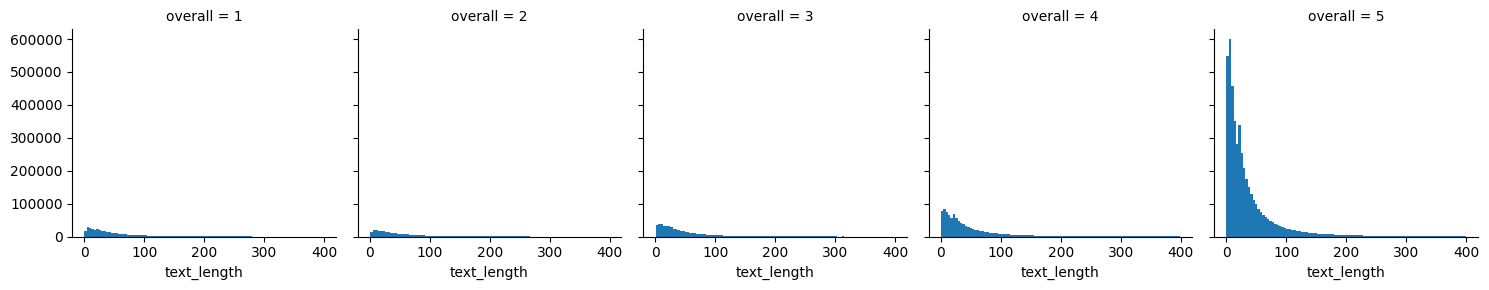

In [52]:
# example to see relationship between overall rating and text length
df['text_length'] = df['reviewText'].apply(lambda text: len(text.split()))
m = sns.FacetGrid(df, col = 'overall')
m.map(plt.hist, 'text_length', bins = 100)
plt.show()

No apparent correlation between ratings and text length <br>
Some reviews are lengthy with more than 300-400 words <br>
Most text lengths are under 100 words

In [53]:
# median number of words in length of text (median used instead of mean for skewed distribution)
df.groupby('overall')['text_length'].median()

overall
1    34.0
2    35.0
3    31.0
4    30.0
5    21.0
Name: text_length, dtype: float64

Lower rated reviews are longer in length <br>
Higher rated reviews are shorter in length

### Subsetting Data

In [54]:
# create a copy of dataset
df1 = df.copy(deep = True)

We will be using only the recent years for this project. 

In [55]:
df1 = df1[df1.year > 2016].reset_index(drop = True)

In [56]:
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image', 'day', 'month', 'year', 'text_length'],
      dtype='object')

In [57]:
# keep ratings, text, and id variables
df1 = df1[['reviewerID', 'asin', 'overall', 'reviewText']]

In [58]:
# rename asin to productID
df1 = df1.rename(columns = {'asin': 'productID'})

In [59]:
# delete duplicates
before_dup = df1.shape[0]
df1 = df1.drop_duplicates()
after_dup = df1.shape[0]

print('There were', before_dup - after_dup, 'duplicate reviews.')

There were 35732 duplicate reviews.


### Generating Labels (Sentiment Scores)

We will be using VADER to generate the necessary sentiment labels for our model. 

VADER ( Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. 

Source: https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

In [118]:
df1.head(7)

,reviewerID,productID,overall,reviewText,scores
0,AT8F6VM9CINXO,1579280633,5,The FONTANINI 5' KNEELING ANGEL is a great add...,"{'neg': 0.116, 'neu': 0.585, 'pos': 0.299, 'co..."
1,A269DFYNBAPGL4,1579280633,5,Beautiful Nativity Angel handpainted by Fontan...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp..."
2,A2R3JI8YFCAK90,1605160113,5,I wanted one of these pictures. I believe in G...,"{'neg': 0.0, 'neu': 0.932, 'pos': 0.068, 'comp..."
3,A2CDLJU98TUNGD,1605160113,5,Only one back of the card was as shown on Amaz...,"{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'comp..."
4,A32Y208W7RLMT3,1605168610,5,This was painted by an eight year old girl who...,"{'neg': 0.0, 'neu': 0.847, 'pos': 0.153, 'comp..."
5,A2AFPK57PC4HXJ,1605168610,4,Smaller than I had invisioned!,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
6,A19OROUWJ9T67I,1605168610,5,I absolutely love this picture of Jesus. I've...,"{'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'comp..."


In [61]:
# VADER (Valence Aware Dictionary and Sentiment Reasoner) 
sid = SentimentIntensityAnalyzer()

df1['scores'] = df1['reviewText'].apply(lambda review: sid.polarity_scores(str(review)))

df1.head()

,reviewerID,productID,overall,reviewText,scores
0,AT8F6VM9CINXO,1579280633,5,The FONTANINI 5' KNEELING ANGEL is a great add...,"{'neg': 0.116, 'neu': 0.585, 'pos': 0.299, 'co..."
1,A269DFYNBAPGL4,1579280633,5,Beautiful Nativity Angel handpainted by Fontan...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp..."
2,A2R3JI8YFCAK90,1605160113,5,I wanted one of these pictures. I believe in G...,"{'neg': 0.0, 'neu': 0.932, 'pos': 0.068, 'comp..."
3,A2CDLJU98TUNGD,1605160113,5,Only one back of the card was as shown on Amaz...,"{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'comp..."
4,A32Y208W7RLMT3,1605168610,5,This was painted by an eight year old girl who...,"{'neg': 0.0, 'neu': 0.847, 'pos': 0.153, 'comp..."


In [62]:
# vader generated scores include scores for negative, positive, neutral, and compound sentiment
df1.scores[0]

{'neg': 0.116, 'neu': 0.585, 'pos': 0.299, 'compound': 0.9444}

In [63]:
# create a copy of cleaned dataset
df2 = df1.copy(deep = True)

In [64]:
# we will be using the compound polarity score to determine the sentiment of the review
df2['vader_compound_scores'] = df2['scores'].apply(lambda score: score['compound'])

In [65]:
# assign correct labels (positive, neutral, negative) to polarity scores
def get_score(score):
    if score < -0.1:
        return -1
    elif score > 0.1:
        return 1
    elif score >= -0.1 and score <= 0.1:
        return 0

In [66]:
# assign sentiment label using vader generated polarity scores
df2.loc[:, 'vader_sentiment'] = df2.vader_compound_scores.apply(lambda score: get_score(score))

# remove neutral sentiment values from vader generated scores(keep only negative and positive labels)
df2 = df2[df2.vader_sentiment.isin([-1, 1])]
df2.loc[:, 'vader_sentiment'] = df2.vader_sentiment.replace(-1, 0)

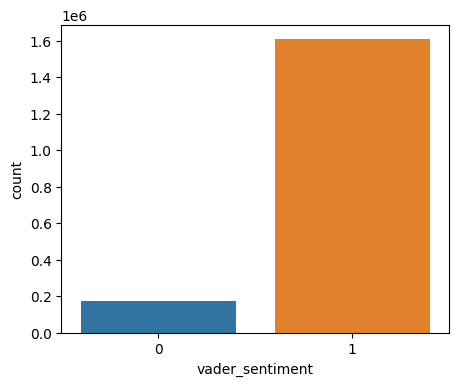

In [67]:
plt.figure(figsize = (5,4))
sns.countplot(x = 'vader_sentiment', data= df2)
plt.show()

As expected, there are a lot more positive reviews than negative

In [68]:
pd.crosstab(df2["vader_sentiment"], df2["overall"], margins=True)

overall,1,2,3,4,5,All
vader_sentiment,,,,,,
0,57035,31345,31181,19210,33829,172600
1,32533,33945,83815,218350,1240018,1608661
All,89568,65290,114996,237560,1273847,1781261


In the table above, there seems to be a mix up between the vader generated sentiment and the overall ratings. <br> 
Some of the lower ratings (1,2) were given a positive sentiment while some of the higher ratings (4,5) were given a negative sentiment. <br> 
To fix this, we will assign all lower ratings (1,2) a negative sentiment and all higher ratings (4,5) a positive sentiment.<br>
As a result of the neutral stance of 3 star ratings, we will assign the sentiments based on the vader generated scores. 

In [69]:
# lower ratings (1,2) assigned a negative sentiments and higher ratings (4,5) assigned a positive sentiment
df2.loc[(df2.vader_sentiment == 1) & (df2.overall < 3), "vader_sentiment"] = 0
df2.loc[(df2.vader_sentiment == 0) & (df2.overall > 3), "vader_sentiment"] = 1

In [70]:
pd.crosstab(df2["vader_sentiment"], df2["overall"], margins = True)

overall,1,2,3,4,5,All
vader_sentiment,,,,,,
0,89568,65290,31181,0,0,186039
1,0,0,83815,237560,1273847,1595222
All,89568,65290,114996,237560,1273847,1781261


In [71]:
df2.vader_sentiment.value_counts()

1    1595222
0     186039
Name: vader_sentiment, dtype: int64

Reviews with 1,2 star ratings were assigned a negative sentiment while reviews with 4,5 star ratings were assigned a positive sentiment. <br>
Reviews with 3 star ratings were assigned sentiments based on the vader scores.

##### Overall Rating Distribution Between Positive and Negative Reviews

In [72]:
# overall rating for positive reviews
df2[df2.vader_sentiment == 1].overall.describe()

count    1.595222e+06
mean     4.745998e+00
std      5.427411e-01
min      3.000000e+00
25%      5.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: overall, dtype: float64

The minimum of overall ratings is 3 and the mean is 4.73 which matches the positive reviews.

In [73]:
# overall rating for negative reviews
df2[df2.vader_sentiment == 0].overall.describe()

count    186039.000000
mean          1.686157
std           0.741996
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: overall, dtype: float64

The maximum is 3 and the mean is 1.69 which matches the negative reviews.

##### Product-wise Analysis

In [156]:
# number of sentiments (positive and negative) for each product
rated_products = pd.DataFrame(df2[['productID', 'overall', 'vader_sentiment', 'vader_compound_scores']])

# count and mean of products
def product_stats(df, sentiment):
    if sentiment == 1:
        return df[df.vader_sentiment == sentiment].groupby('productID').agg({'vader_compound_scores': 'size', 'overall': 'mean'}).rename(
        columns = {'vader_compound_scores': 'pos_count', 'overall': 'pos_mean'}).sort_values('pos_count', ascending = False).reset_index()
    elif sentiment == 0:
        return df[df.vader_sentiment == sentiment].groupby('productID').agg({'vader_compound_scores': 'size', 'overall': 'mean'}).rename(
        columns = {'vader_compound_scores': 'neg_count', 'overall': 'neg_mean'}).sort_values('neg_count', ascending = False).reset_index()

In [157]:
# positive reviews
pos_rated = product_stats(rated_products, 1)
pos_rated.head(10)

,productID,pos_count,pos_mean
0,B00FLYWNYQ,4009,4.876029
1,B00Q7EV29G,2261,4.760725
2,B01G7SBOF8,1844,4.881236
3,B01G7SGOL2,1842,4.882193
4,B01CMT8DFU,1830,4.881421
5,B009HVH4XO,1782,4.774972
6,B00LV4W8BI,1433,4.752966
7,B018UQ5AMS,1158,4.769430
8,B00DDXWFY0,1144,4.770105
9,B00NLLUNSE,1128,4.743794


In [158]:
# negative reviews
neg_rated = product_stats(rated_products, 0)
neg_rated.head(10)

,productID,neg_count,neg_mean
0,B00Q7EV29G,312,1.535256
1,B00FLYWNYQ,272,1.709559
2,B00BC0SPIQ,234,1.487179
3,B018UQ5AMS,212,1.485849
4,B009HVH4XO,211,1.668246
5,B00EQT70QS,210,1.533333
6,B00ARQVLGO,208,1.538462
7,B00EINBSJ2,203,1.605911
8,B00LV4W8BI,200,1.600000
9,B00X8KSKF6,161,1.633540


In [162]:
# each product with its positive and negative counts and mean of ratings
comb_rated = pd.merge(pos_rated, neg_rated, how = 'inner', on  = 'productID')
comb_rated.head(15)

,productID,pos_count,pos_mean,neg_count,neg_mean
0,B00FLYWNYQ,4009,4.876029,272,1.709559
1,B00Q7EV29G,2261,4.760725,312,1.535256
2,B01G7SBOF8,1844,4.881236,62,1.677419
3,B01G7SGOL2,1842,4.882193,62,1.677419
4,B01CMT8DFU,1830,4.881421,62,1.677419
5,B009HVH4XO,1782,4.774972,211,1.668246
6,B00LV4W8BI,1433,4.752966,200,1.600000
7,B018UQ5AMS,1158,4.769430,212,1.485849
8,B00DDXWFY0,1144,4.770105,91,1.857143
9,B00NLLUNSE,1128,4.743794,143,1.713287


Products with high positive review counts have relatively low counts negative reviews <br>
This makes sense because of the skewed distribution of positive and negative reviews

### Text Preprocessing

In [79]:
df3 = df2.copy(deep = True)

In [80]:
# create new column with lower cased reviews
df3['lowercase_reviews'] = df3['reviewText'].str.lower()

In [81]:
# remove punctuation from the reviews
df3['punc_reviews'] = df3['lowercase_reviews'].str.translate(str.maketrans('', '', string.punctuation))

In [82]:
# remove extra spaces, tabs, and line breaks
df3['space_tab_break_reviews'] = df3['punc_reviews'].apply(lambda text: ' '.join(text.split()))

In [83]:
# remove numbers (not very informative)
df3['numbers_reviews'] = df3['space_tab_break_reviews'].apply(lambda text: re.sub(r"\b[0-9]+\b\s*", "", text))

In [84]:
# remove stopwords (words that do not add significant meaning to the review) and lemmatize remaining words (transform word to root)
wnl = WordNetLemmatizer()
stop_words = stopwords.words('english')

df3['reviews'] = df3['numbers_reviews'].apply(lambda text: ' '.join([wnl.lemmatize(word) for word in text.split() if word not in stop_words]))

In [85]:
# delete empty rows in review column (emoticons)
df3 = df3[df3.reviews != '']

In [86]:
df3.columns

Index(['reviewerID', 'productID', 'overall', 'reviewText', 'scores',
       'vader_compound_scores', 'vader_sentiment', 'lowercase_reviews',
       'punc_reviews', 'space_tab_break_reviews', 'numbers_reviews',
       'reviews'],
      dtype='object')

In [87]:
df4 = df3[['reviewerID', 'productID', 'overall', 'reviews', 'vader_sentiment']].copy(deep = True)

In [88]:
df4.head(5)

,reviewerID,productID,overall,reviews,vader_sentiment
0,AT8F6VM9CINXO,1579280633,5,fontanini kneeling angel great addition nativi...,1
1,A269DFYNBAPGL4,1579280633,5,beautiful nativity angel handpainted fontanini...,1
2,A2R3JI8YFCAK90,1605160113,5,wanted one picture believe god saw card pictur...,1
3,A2CDLJU98TUNGD,1605160113,5,one back card shown amazon wanted lord promise...,1
4,A32Y208W7RLMT3,1605168610,5,painted eight year old girl claim visited jesu...,1


##### Vectorizing Text

In [89]:
X = df4['reviews']
y = df4['vader_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.11, shuffle = True, stratify = y_train)

In [90]:
# reset the index for use in the stratified k fold
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)

In [91]:
# tfidf to vectorize the review text
tfidf = TfidfVectorizer(analyzer = 'word', stop_words = 'english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_val_tfidf = tfidf.transform(X_val)

### Building and Testing ML Models

We will be testing out multiple models including Logistic Regression, Boosting techniques, and Voting Classifer.

We will be focusing on increasing the accuracy of predictions of the minority class <br>
We want to focus on minimizing the number of false positives and false negatives. <br> 
This is the similar to maximizing precision and recall which have an inverse relationship with one another. <br>
However, for this specific case, we will put more weight/focus on minimizing false positives. <br>
This is because companies should be very aware of any sort of complaint/issue with their products/service in order to fix those problems. <br>
It would be detrimental to the company if a negative review was labelled as positive which would leave the problem/issue go unnoticed. 

#### Class Imbalance: Undersampling Training Data

We will first try Logistic Regression on an undersampled dataset

In [92]:
X = df4['reviews']
y = df4['vader_sentiment']

X_train_und, X_test_und, y_train_und, y_test_und = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

In [93]:
y_train_und.value_counts()

1    1275878
0     148795
Name: vader_sentiment, dtype: int64

In [94]:
# undersampling based on the minority class 
Xtrainpos = X_train_und[y_train_und[y_train_und == 1][:149335].index]
ytrainpos = y_train_und[y_train_und == 1][:149335]
Xtrainneg = X_train_und[y_train_und[y_train_und == 0][:149335].index]
ytrainneg = y_train_und[y_train_und == 0][:149335]
X_comb = pd.concat([Xtrainpos, Xtrainneg])
y_comb = pd.concat([ytrainpos, ytrainneg])

In [95]:
# vectorizing text of undersampled dataset
tfidf = TfidfVectorizer(analyzer = 'word', stop_words = 'english')
X_comb_tfidf = tfidf.fit_transform(X_comb)
X_test_und_tfidf = tfidf.transform(X_test_und)

In [96]:
# train model on undersampled dataset
lr = LogisticRegression(max_iter = 10000)
lr.fit(X_comb_tfidf, y_comb)
y_pred_und = lr.predict(X_test_und_tfidf)
print(classification_report(y_test_und, y_pred_und))

              precision    recall  f1-score   support

           0       0.47      0.89      0.61     37199
           1       0.99      0.88      0.93    318970

    accuracy                           0.88    356169
   macro avg       0.73      0.89      0.77    356169
weighted avg       0.93      0.88      0.90    356169



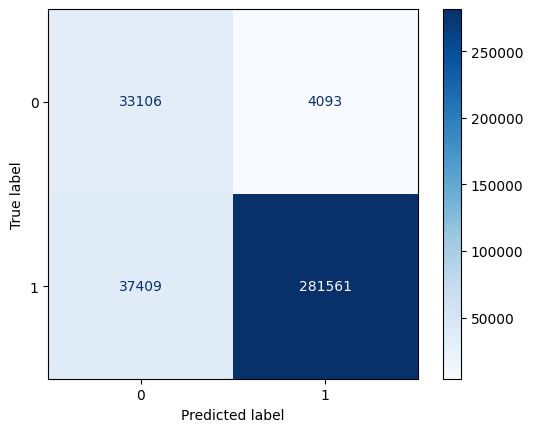

In [97]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_und, y_pred_und, cmap = 'Blues')

The model trained on the undersampled dataset performs decently. <br>
The decrease in the number of false positives comes at the cost of dramatically increasing the number of false negatives. <br>

##### Stratified K-Fold

In [324]:
# model performance for future storing 
model_metrics = pd.DataFrame()
kfoldperf = pd.DataFrame()
min_metrics = pd.DataFrame()

In [325]:
# stratified k fold on the training set
def stratified_kfold(model):
    skf = StratifiedKFold(n_splits = 5)
    scores = []
    
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        tfidf = TfidfVectorizer()
        X_train_tfidf = tfidf.fit_transform(X_train_fold)
        X_test_tfidf = tfidf.transform(X_test_fold)

        model.fit(X_train_tfidf, y_train_fold)
        y_pred = model.predict(X_test_tfidf)
        scores.append(f1_score(y_test_fold, y_pred))

    kfoldperf[type(model).__name__] = np.mean(scores)
    print('*' * 30)
    print('Stratified K Fold Cross Validation on Training Set')
    print('F1 Scores:', scores)
    print(f'Mean F1 Scores: {np.mean(scores) * 100:.2f}%')

##### Class for Using Model

In [326]:
class model:
    def __init__(self, model, X_train, y_train, X_test, y_test):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    

    # training the model and outputting predictions
    def train_model(self):
        self.model.fit(self.X_train, self.y_train)
        return self.model.predict(self.X_test)


    # calculate scores for the general model
    def get_scores(self, model_metrics, y_pred):
        scores = []
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)

        print(f'Accuracy Score: {accuracy * 100:.2f}%')
        print(f'Precision Score: {precision * 100:.2f}%')
        print(f'Recall Score: {recall * 100:.2f}%')
        print(f'F1 Score: {f1 * 100:.2f}%')

        scores.append(round(accuracy, 2))
        scores.append(round(precision, 2))
        scores.append(round(recall, 2))
        scores.append(round(f1, 2))

        model_metrics[type(self.model).__name__] = scores


    # print classification report
    def print_classification(self, y_pred):
        print(classification_report(self.y_test, y_pred))


    # plot confusion matrix 
    def print_confusion(self, y_pred):
        plt.figure(figsize = (5,5))
        disp = ConfusionMatrixDisplay.from_predictions(self.y_test, y_pred, cmap = 'Blues')


    # calculating scores for the minority class
    def minority_class(self, min_metrics, y_pred):
        min_scores = []
        conf = confusion_matrix(self.y_test, y_pred)
        min_recall = conf[0][0] / (conf[0][0] + conf[0][1])
        min_precision = conf[0][0] / (conf[0][0] + conf[1][0])
        min_f1 = 2 * ((min_precision * min_recall) / (min_precision + min_recall))

        min_scores.append(round(min_precision, 2))
        min_scores.append(round(min_recall, 2))
        min_scores.append(round(min_f1, 2))

        min_metrics[type(self.model).__name__] = min_scores


    # building and testing the model
    def evaluate_model(self, y_pred):
        print('*' * 30)
        print('Testing Set Performance')
        self.get_scores(model_metrics, y_pred)
        print('*' * 30)
        self.print_classification(y_pred)
        print('*' * 30)
        self.print_confusion(y_pred)
        self.minority_class(min_metrics, y_pred)

##### Logistic Regression

******************************
Stratified K Fold Cross Validation on Training Set
F1 Scores: [0.9692830526388879, 0.9691744633587609, 0.9690886326499509, 0.9694161939681029, 0.9690858815498711]
Mean F1 Scores: 96.92%
******************************
Testing Set Performance
Accuracy Score: 94.20%
Precision Score: 95.41%
Recall Score: 98.26%
F1 Score: 96.81%
******************************
              precision    recall  f1-score   support

           0       0.80      0.59      0.68     18599
           1       0.95      0.98      0.97    159486

    accuracy                           0.94    178085
   macro avg       0.88      0.79      0.82    178085
weighted avg       0.94      0.94      0.94    178085

******************************


<Figure size 500x500 with 0 Axes>

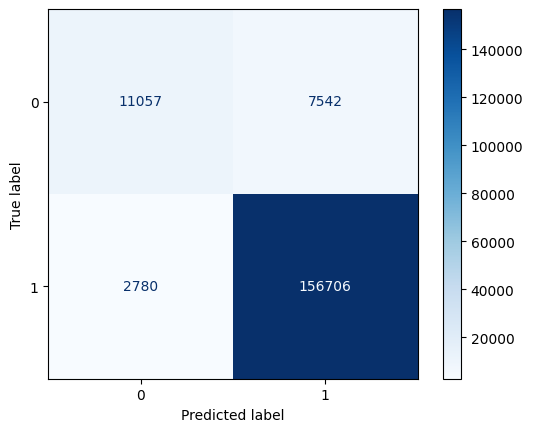

In [327]:
lr = LogisticRegression(max_iter = 10000)

stratified_kfold(lr)
use_model = model(lr, X_train_tfidf, y_train, X_test_tfidf, y_test)
y_pred = use_model.train_model()
use_model.evaluate_model(y_pred)

This is a great base model to begin with. <br> 
The model does very well in minimizing both the number of false positives and false negatives. <br>
The model could use some improvement in further increasing its performance in lowering the number of false positives.

##### Naive Bayes

******************************
Stratified K Fold Cross Validation on Training Set
F1 Scores: [0.9493173547636483, 0.9494144763745864, 0.9493271184015136, 0.9494644563330223, 0.9493012191495688]
Mean F1 Scores: 94.94%
******************************
Testing Set Performance
Accuracy Score: 90.58%
Precision Score: 90.52%
Recall Score: 99.94%
F1 Score: 95.00%
******************************
              precision    recall  f1-score   support

           0       0.96      0.10      0.19     18599
           1       0.91      1.00      0.95    159486

    accuracy                           0.91    178085
   macro avg       0.93      0.55      0.57    178085
weighted avg       0.91      0.91      0.87    178085

******************************


<Figure size 500x500 with 0 Axes>

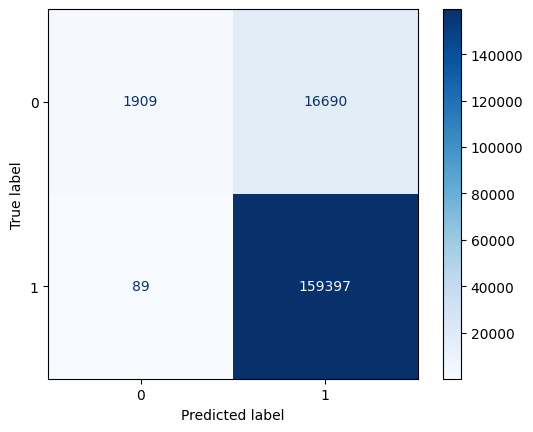

In [328]:
mnb = MultinomialNB(alpha=1.0)

stratified_kfold(mnb)
use_model = model(mnb, X_train_tfidf, y_train, X_test_tfidf, y_test)
y_pred = use_model.train_model()
use_model.evaluate_model(y_pred)

This model performs very poorly with a dramatic increase in false positives.

##### XGB Classifier

******************************
Stratified K Fold Cross Validation on Training Set
F1 Scores: [0.9641704743960393, 0.9639161009792541, 0.964187023111852, 0.9640755332984984, 0.9640147578961418]
Mean F1 Scores: 96.41%
******************************
Testing Set Performance
Accuracy Score: 93.30%
Precision Score: 93.92%
Recall Score: 98.93%
F1 Score: 96.36%
******************************
              precision    recall  f1-score   support

           0       0.83      0.45      0.58     18599
           1       0.94      0.99      0.96    159486

    accuracy                           0.93    178085
   macro avg       0.88      0.72      0.77    178085
weighted avg       0.93      0.93      0.92    178085

******************************


<Figure size 500x500 with 0 Axes>

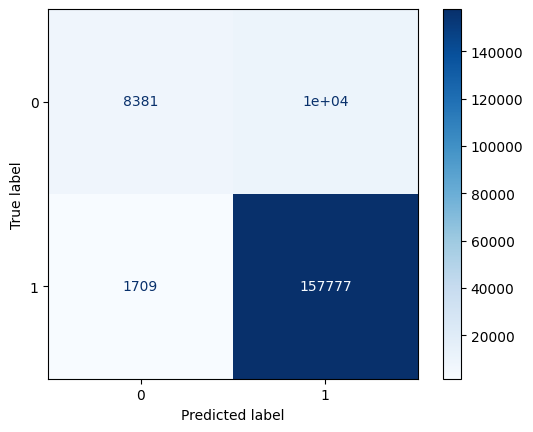

In [329]:
xgb = XGBClassifier()

stratified_kfold(xgb)
use_model = model(xgb, X_train_tfidf, y_train, X_test_tfidf, y_test)
y_pred = use_model.train_model()
use_model.evaluate_model(y_pred)

##### LGBM Classifier

******************************
Stratified K Fold Cross Validation on Training Set
F1 Scores: [0.9646251916095585, 0.9646482230375747, 0.964644134823546, 0.9646547764849969, 0.9645125740437451]
Mean F1 Scores: 96.46%
******************************
Testing Set Performance
Accuracy Score: 93.36%
Precision Score: 94.25%
Recall Score: 98.60%
F1 Score: 96.38%
******************************
              precision    recall  f1-score   support

           0       0.80      0.48      0.60     18599
           1       0.94      0.99      0.96    159486

    accuracy                           0.93    178085
   macro avg       0.87      0.74      0.78    178085
weighted avg       0.93      0.93      0.93    178085

******************************


<Figure size 500x500 with 0 Axes>

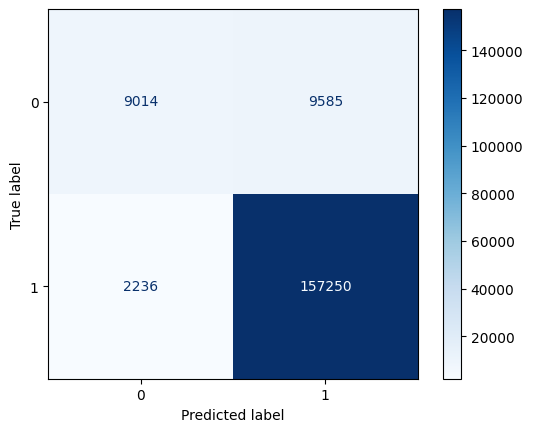

In [330]:
# hard voting
lgbm = LGBMClassifier()

stratified_kfold(lgbm)
use_model = model(lgbm, X_train_tfidf, y_train, X_test_tfidf, y_test)
y_pred = use_model.train_model()
use_model.evaluate_model(y_pred)

##### Soft Voting Classifier

******************************
Stratified K Fold Cross Validation on Training Set
F1 Scores: [0.9674275956074924, 0.9672216172353012, 0.9672005605694528, 0.9675281034413433, 0.9670982497440167]
Mean F1 Scores: 96.73%
******************************
Testing Set Performance
Accuracy Score: 93.86%
Precision Score: 94.54%
Recall Score: 98.85%
F1 Score: 96.65%
******************************
              precision    recall  f1-score   support

           0       0.84      0.51      0.63     18599
           1       0.95      0.99      0.97    159486

    accuracy                           0.94    178085
   macro avg       0.89      0.75      0.80    178085
weighted avg       0.93      0.94      0.93    178085

******************************


<Figure size 500x500 with 0 Axes>

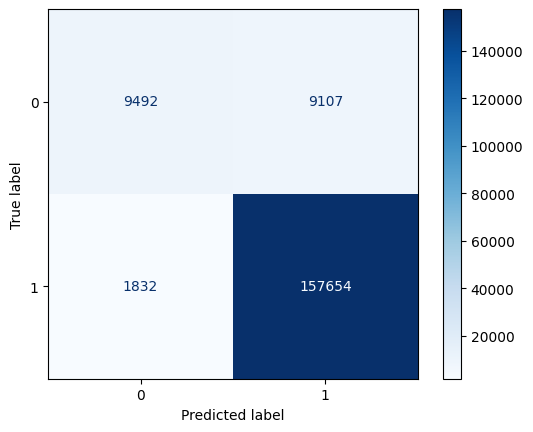

In [331]:
# soft voting
vc = VotingClassifier(estimators = [('LR', lr), ('XGB', xgb), ('lgbm', lgbm)], voting='soft')

stratified_kfold(vc)
use_model = model(vc, X_train_tfidf, y_train, X_test_tfidf, y_test)
y_pred = use_model.train_model()
use_model.evaluate_model(y_pred)

#### Model Selection

In [332]:
model_metrics.index = ['Accuracy', 'Precision', 'Recall', 'F1']
model_metrics

,LogisticRegression,MultinomialNB,XGBClassifier,LGBMClassifier,VotingClassifier
Accuracy,0.94,0.91,0.93,0.93,0.94
Precision,0.95,0.91,0.94,0.94,0.95
Recall,0.98,1.00,0.99,0.99,0.99
F1,0.97,0.95,0.96,0.96,0.97


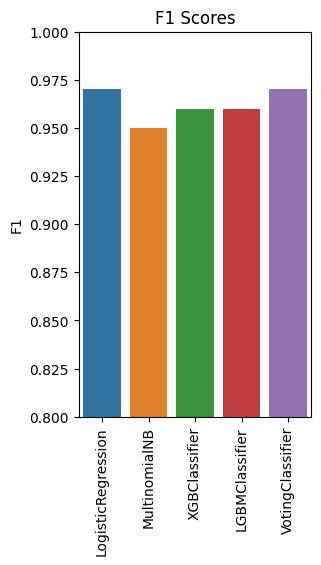

In [343]:
plt.figure(figsize = (3, 5))
sns.barplot(x = model_metrics.columns, y = model_metrics.iloc[3,:])
plt.xticks(rotation = 90)
plt.title('F1 Scores')
plt.ylim([0.8, 1])
plt.show()

In [334]:
# tranposing dataframe for further visualizations
min_metrics.index = ['Precision', 'Recall', 'F1']
min_metrics = min_metrics.T
min_metrics = min_metrics.reset_index().rename(columns = {'index': 'Models'})
min_metrics

,Models,Precision,Recall,F1
0,LogisticRegression,0.80,0.59,0.68
1,MultinomialNB,0.96,0.10,0.19
2,XGBClassifier,0.83,0.45,0.58
3,LGBMClassifier,0.80,0.48,0.60
4,VotingClassifier,0.84,0.51,0.63


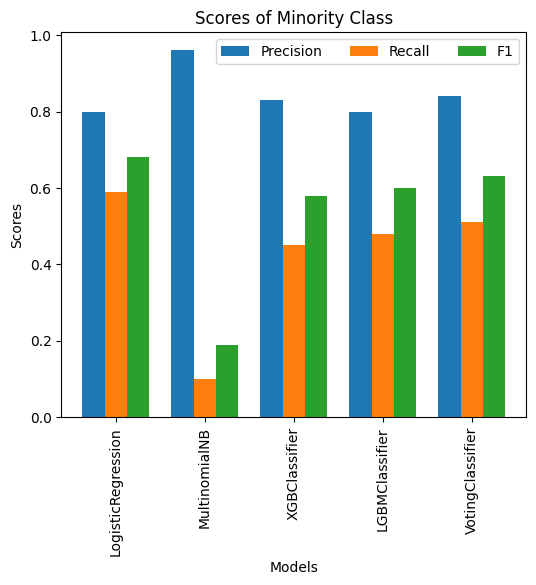

In [357]:
# graphing scores of models based on the minority class
names = min_metrics.Models
precision = min_metrics.Precision
recall = min_metrics.Recall
f1 = min_metrics.F1

xlength = np.arange(len(names))

plt.figure(figsize = (6,5))
plt.bar(xlength - 0.25, precision, 0.25, label = 'Precision')
plt.bar(xlength, recall, 0.25, label = 'Recall')
plt.bar(xlength + 0.25, f1, 0.25, label = 'F1')


plt.xticks(xlength, names, rotation = 90)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Scores of Minority Class')
plt.legend(loc = 'upper right', ncol = 3)
plt.show()

Logistic Regression and Voting Classifier had the slight edge in F1 scores (Voting Classifier is much more computationally intensive) <br>
Logistic Regression had the slight edge in recall and f1 score over the other models for the minority class predictions <br>

### Logistic Regression Hyperparameter Tuning

Best:  0.9682170579609843 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
************************************************************
              precision    recall  f1-score   support

           0       0.80      0.59      0.68     18599
           1       0.95      0.98      0.97    159486

    accuracy                           0.94    178085
   macro avg       0.88      0.79      0.82    178085
weighted avg       0.94      0.94      0.94    178085

************************************************************


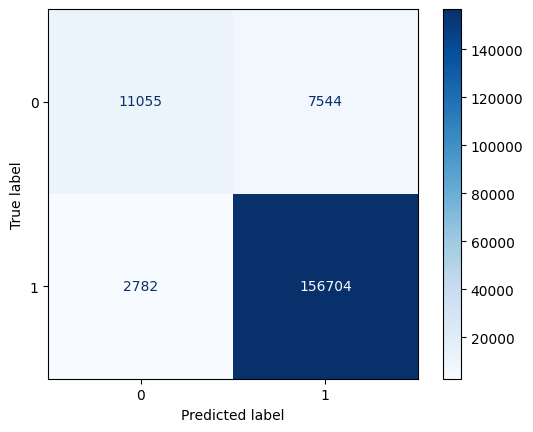

In [189]:
lr = LogisticRegression(max_iter = 10000)
log_params = {'C': [100, 10, 1.0, 0.1, 0.01], 
              'penalty': ['l2'], 
              'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag']}


grid_search = GridSearchCV(estimator = lr, param_grid = log_params, n_jobs = -1, cv = 5, scoring = 'f1')
grid_result = grid_search.fit(X_train_tfidf, y_train)
print('Best: ', grid_result.best_score_, 'using', grid_result.best_params_)

print('*' * 60)

grid_model = grid_result.best_estimator_
grid_model.fit(X_train_tfidf, y_train)
y_pred_lr = grid_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_lr))

print('*' * 60)

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap = 'Blues')

The hyperparameter tuned logistic regression model resulted in nearly identical scores compared to the original logistic regression model.

### Precision Recall Threshold Optimization

We will try different thresholds in our precision-recall curve in order to maximize the predictive capability of our model.

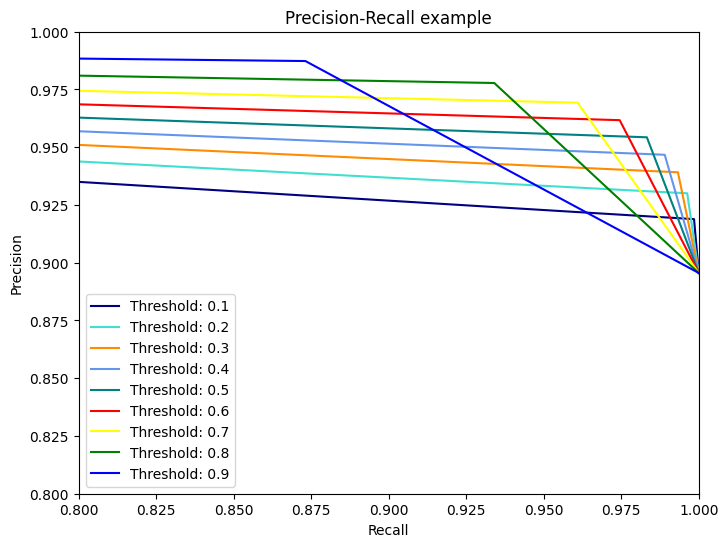

In [356]:
# model trained on training set and tested on validation set
lr = LogisticRegression(max_iter = 10000)
lr.fit(X_train_tfidf, y_train)
y_pred_lr_proba = lr.predict_proba(X_val_tfidf)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black']

plt.figure(figsize=(8,6))

for i,color in zip(thresholds,colors):
    y_pred_lr_test = y_pred_lr_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_lr_test)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color = color, label = 'Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.8, 1.0])
    plt.xlim([0.8, 1.0])
    plt.title('Precision-Recall Curves')
    plt.legend(loc = "lower left")

In [360]:
# choosing best threshold to increase f1 score of both minority and majority class
y_pred_lr_final = y_pred_lr_proba[:,1] > 0.7
print(classification_report(y_val, y_pred_lr_final))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71     18414
           1       0.97      0.96      0.97    157890

    accuracy                           0.94    176304
   macro avg       0.83      0.85      0.84    176304
weighted avg       0.94      0.94      0.94    176304



In [366]:
# testing threshold on the test set
y_pred = lr.predict_proba(X_test_tfidf)
y_pred_final = y_pred[:,1] > 0.7
print('Optimized Logistic Regresion Model (Precision Recall Threshold)')
print(classification_report(y_test, y_pred_final))

Optimized Logistic Regresion Model (Precision Recall Threshold)
              precision    recall  f1-score   support

           0       0.68      0.74      0.71     18599
           1       0.97      0.96      0.96    159486

    accuracy                           0.94    178085
   macro avg       0.83      0.85      0.84    178085
weighted avg       0.94      0.94      0.94    178085



Original Logistic Regression Model

                precision    recall  f1-score   support

           0       0.81      0.61      0.70     28000
           1       0.96      0.98      0.97    239738

Undersampled Logistic Regression Model
  
                precision    recall  f1-score   support

           0       0.47      0.89      0.61     37334
           1       0.99      0.88      0.93    319650

Compared to the original logistic regression model, we can see that while the precision score of the minority class dropped, the recall score of the same class increased dramatically. <br>
This means that the model's ability to predict a negative sentiment increased while its ability to predict the majority class of positive sentiments remains highly accurate.

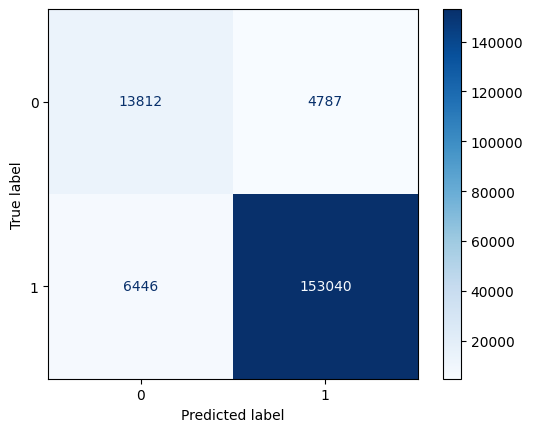

In [205]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final, cmap = 'Blues')

The optimized model's ability to identify a negative sentiment has significantly gotten better. <br>
From a business case perspective, it may be more beneficial to use a model that is better at predicting the negative sentiment cases in order to address issues and complaints from customers. <br>
This model did just that by decreasing the number of false positives so as to not dramatically increase the number of false negatives.

&nbsp;


&nbsp;

&nbsp;

### Artificial Neural Network (In Progress)

In [559]:
# splitting data into training and testing set
X = df4['reviews']
y = df4['vader_sentiment']

X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [560]:
# resetting index
X_train_ann = X_train_ann.reset_index(drop = True)
X_test_ann = X_test_ann.reset_index(drop = True)
y_train_ann = y_train_ann.reset_index(drop = True)
y_test_ann = y_test_ann.reset_index(drop = True)

#undersampling based on the minority class 
X_train_ann_pos = X_train_ann[y_train_ann[y_train_ann == 1][:148795].index]
y_train_ann_pos = y_train_ann[y_train_ann == 1][:148795]
X_train_ann_neg = X_train_ann[y_train_ann[y_train_ann == 0][:148795].index]
y_train_ann_neg = y_train_ann[y_train_ann == 0][:148795]
X_train_ann = pd.concat([X_train_ann_pos, X_train_ann_neg])
y_train_ann = pd.concat([y_train_ann_pos, y_train_ann_neg])

In [561]:
max_len = max(len(sentence.split()) for sentence in X)

tokenizer = Tokenizer()
# update vocabulary based on training set 
tokenizer.fit_on_texts(X_train_ann)

# transform text into sequence of integers based on updated vocabulary
# words known by tokenizer will be taken into account
X_train_ann = tokenizer.texts_to_sequences(X_train_ann)
X_test_ann = tokenizer.texts_to_sequences(X_test_ann)

# transform list of sequences to numpy array (2D)
# max length is the longest length of a sentence in the list
# must be same length for it to be trained
X_train_ann = pad_sequences(X_train_ann, maxlen = max_len)
X_test_ann = pad_sequences(X_test_ann, maxlen = max_len)

In [572]:
# artificial neural network
model = Sequential()

model.add(Embedding(85000, 32, input_length = max_len)) 
model.add(Flatten())

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

Epoch 1/10
2325/2325 [==============================] - 36s 15ms/step - loss: 0.0861 - val_loss: 1.2038
Epoch 2/10
2325/2325 [==============================] - 34s 15ms/step - loss: 0.0823 - val_loss: 1.0745
Epoch 3/10
2325/2325 [==============================] - 34s 14ms/step - loss: 0.0792 - val_loss: 1.2296
Epoch 4/10
2325/2325 [==============================] - 33s 14ms/step - loss: 0.0763 - val_loss: 1.3080
Epoch 5/10
2325/2325 [==============================] - 33s 14ms/step - loss: 0.0736 - val_loss: 1.5296
Epoch 5: early stopping


<AxesSubplot:>

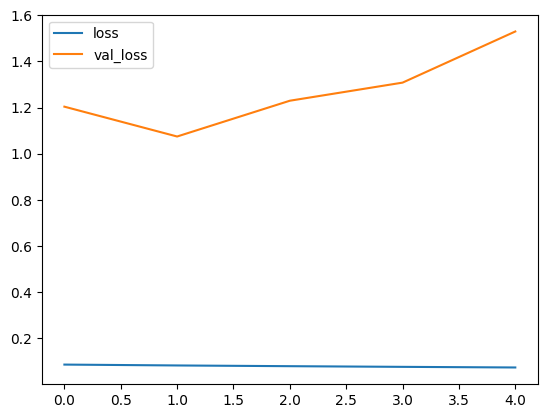

In [575]:
# automatically stop training if validation loss increases while training loss continues to decrease
# patience is number of epochs to continue training before stopping training
# minimum of validation loss is stopping point
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

# number of epochs is number of times to run through the whole dataset
# validation data is to prevent overfitting
# callback is calling early stop to stop training once validation loss starts to increase
model.fit(x = X_train_ann, y = y_train_ann, epochs = 10,  validation_data = (X_test_ann, y_test_ann), callbacks = [early_stop], batch_size = 128)

# plot training and validation loss
losses = pd.DataFrame(model.history.history)
losses.plot()

In [576]:
y_pred_ann = (model.predict(X_test_ann) > 0.5).astype("int32")
print(classification_report(y_test_ann, y_pred))

11131/11131 [==============================] - 9s 801us/step
              precision    recall  f1-score   support

           0       0.10      1.00      0.19     37119
           1       0.00      0.00      0.00    319050

    accuracy                           0.10    356169
   macro avg       0.05      0.50      0.09    356169
weighted avg       0.01      0.10      0.02    356169



c:\Users\chaer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\chaer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\chaer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,